# 1D Heat equation; MLP

In [237]:
# initial plot
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import pandas as pd
from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from PIL import Image

We will store the temperature u, at a given x,t in a 2D tensor called U(t,x)

In [238]:
# setup time-space geometry
num_points = 51
x_start = 0
x_stop = 1
num_timesteps = 1000
t_start = 0
t_stop = 1 

# 2D array to hold U(x,t)
x = np.linspace(start=x_start, stop=x_stop, num=num_points)
t = np.linspace(start=t_start, stop=t_stop, num=num_timesteps)
U = np.zeros((t.shape[0],x.shape[0]))
print(U.shape)

#Thermal diffusivity
alpha = 1.22e-3

#Numerical stability constraints
dx = x[1] - x[0] 
dt = 0.5 * dx**2 / alpha
sigma = alpha * dt / dx**2

#Intital conditions at t=0
U[0][:] = np.sin(np.pi * x)

# plot factor
plot_factor = int(np.floor(num_timesteps / 5))

(1000, 51)


In [239]:
def delta_heat(u):
    sigma = alpha * dt / dx**2
    return (sigma * (u[2:] - 2*u[1:-1] + u[:-2]))

plotting at timestep 0
plotting at timestep 200
plotting at timestep 400
plotting at timestep 600
plotting at timestep 800


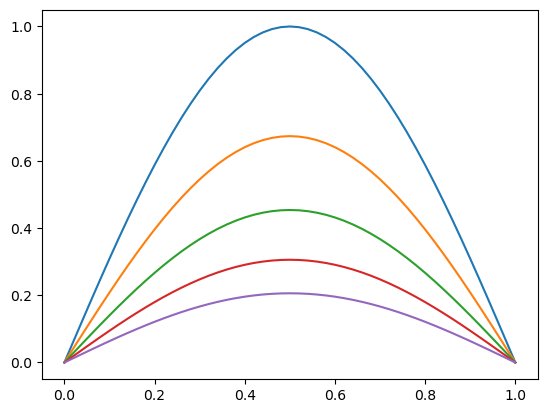

In [240]:
# evolve the heat over all timesteps
for tstep in range(len(t)):
    if tstep == 0:
        print(f"plotting at timestep 0")
        plt.plot(x,U[tstep][:])
        continue
    U[tstep][1:-1] = U[tstep-1][1:-1] + delta_heat(U[tstep-1][:])
    if tstep % plot_factor == 0:
        print(f"plotting at timestep {tstep}")
        plt.plot(x,U[tstep][:])

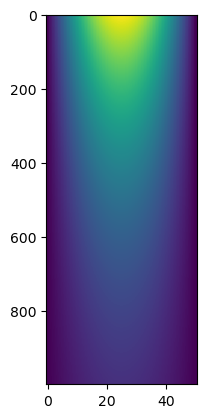

In [241]:
#Plot 2D heat diffusion using imshow
# - x axis is space
# - y axis is time
plt.imshow(U, aspect=0.125)

In [242]:
#Save numpy array to file to avoid having to recreate it every time
#Not a big deal here but will help when we extend to larger problem sizes
np.save("./1d-heat",U)

## Classic MLP Neural Network to learn the 1D-heat diffusion equation

The goal of the following section is to show the failure of MLP with no physics constraints

Prepare data for model tranining by extend the Dataset class to use our custom data \
Following this tutorial: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

- Use Dataset to store the samples and their corresponding labels
- DataLoader wraps an iterable around the Dataset to enable easy access to the samples

In [243]:
U_load = np.load("./1d-heat.npy")
print(U_load.shape)

(1000, 51)


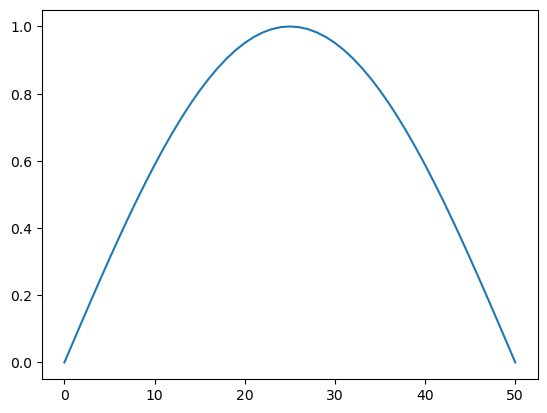

In [244]:
plt.plot(U_load[0,:])


In [245]:
features = np.ones((U_load.shape[0]*U_load.shape[1],2))
features[:,1] = np.tile(x,U_load.shape[0])
features[:,0] = np.repeat(t,U_load.shape[1])
print(features[0:5])
print(features[-5:])

[[0.   0.  ]
 [0.   0.02]
 [0.   0.04]
 [0.   0.06]
 [0.   0.08]]
[[1.   0.92]
 [1.   0.94]
 [1.   0.96]
 [1.   0.98]
 [1.   1.  ]]


In [246]:
labels = np.ones((U_load.shape[0]*U_load.shape[1],1))
labels = U_load.ravel()
labels[0:5]

array([0.        , 0.06279052, 0.12533323, 0.18738131, 0.24868989])

In [247]:
labels = labels.astype(np.float32)
features = features.astype(np.float32)

At this point we have got our data from a saved file into two tensors.
A 1-D tensor of output temperatures and a 2D tensor of space (x) and time (t) input values.

Now we need to seperate training data from testing data. \
What else needs to happen....scale it? Cross-validation? How do these techniques fit into DNN?
Possivly use normalize as a transform that gets pased to the dataset class

In [248]:
### Pre-processing stage
std_scaler = StandardScaler()
scaler_features = std_scaler.fit(features)
scaled_features = scaler_features.transform(features)

print(f"\nPre-scaling:\n {features[0:5]}")
print(f"Mean: {features.mean()} Std: {features.std()}")
print(f"\nPost-scaling:\n {scaled_features[0:5]}")
print(f"Mean: {scaled_features.mean()} Std: {scaled_features.std()}")


Pre-scaling:
 [[0.   0.  ]
 [0.   0.02]
 [0.   0.04]
 [0.   0.06]
 [0.   0.08]]
Mean: 0.5000000596046448 Std: 0.2916906177997589

Post-scaling:
 [[-1.7303196 -1.6984155]
 [-1.7303196 -1.6304789]
 [-1.7303196 -1.5625423]
 [-1.7303196 -1.4946057]
 [-1.7303196 -1.426669 ]]
Mean: 2.1541818995274298e-08 Std: 1.0


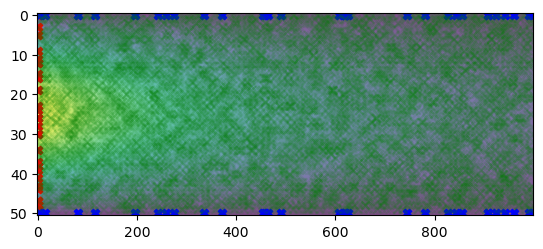

In [249]:
colo_initial = 30
colo_boundary = 30
colo_interior_pts = int(0.2*(num_points * num_timesteps))

# Set random seed for reproducible results
np.random.seed(1234)

# Get a uniform sample locations for initial condition data
init_t_coord = np.ones((colo_initial,1), dtype=int).ravel() * 0
init_x_coord = np.random.randint(0, num_points-1, colo_initial)

#Plot initial condition locations in red:
plt.scatter(init_t_coord, init_x_coord, marker='X',c="red")

# Get a uniform sample location for left and right spatial boundary data
x0_bound_t_coord = np.random.randint(0, num_timesteps-1, colo_boundary)
x0_bound_x_coord = np.ones((colo_boundary,1), dtype=int).ravel() * 0
xstop_bound_t_coord = x0_bound_t_coord
xstop_bound_x_coord = np.ones((colo_boundary,1), dtype=int).ravel() * (num_points-1)

#Plot boundary condition locations in blue:
plt.scatter(x0_bound_t_coord, x0_bound_x_coord, marker='X',c="blue")
plt.scatter(xstop_bound_t_coord, xstop_bound_x_coord, marker='X',c="blue")

# Get a uniform sample location for interior data (80% of all remaining data)
x_interior_t_coord = np.random.randint(0,num_timesteps-1,colo_interior_pts)
x_interior_x_coord = np.random.randint(0,num_points-1,colo_interior_pts)

#Plot boundary condition locations in green:
plt.scatter(x_interior_t_coord, x_interior_x_coord, marker='x',c="green", alpha=0.1)

plt.imshow(U.transpose(), aspect=8, alpha=0.7)


Now use these colocation coordinates to extract training (and testing) data from simulated solution

In [250]:
#Reshape locations into indexes to index into simulated data
init_data = U_load[init_t_coord,init_x_coord]
left_boundary_data = U_load[x0_bound_t_coord,x0_bound_x_coord]
right_boundary_data = U_load[xstop_bound_t_coord,xstop_bound_x_coord]
colo_data = U_load[x_interior_t_coord,x_interior_x_coord]

print(init_data.shape)
print(left_boundary_data.shape)
print(right_boundary_data.shape)
print(colo_data.shape)

(30,)
(30,)
(30,)
(10200,)


In [251]:
# Get feature data for initial condition, boundary condition and interior points
features_init = features[0:51]
print(f"Init shape: {features_init.shape}")

features_x0 = features[0::51]
features_xstop = features[50::51]
print(f"Left bound shape: {features_x0.shape}")
print(f"Right bound shape: {features_xstop.shape}")
features_bound = np.append(features_x0, features_xstop, axis=0)
print(f"Both bounds shape: {features_bound.shape}")

features_interior = np.empty((0,1))
start=1
block_size=49
skip=2
while start < features.shape[0]:
    features_interior = np.append(features_interior, features[start:start+block_size])
    start = start + block_size + skip

length = features_interior.ravel().shape[0]
features_interior = features_interior.reshape((int(length/2),2))
print(f"Interior shape: {features_interior.shape}")

#Now split them into x and t
t_init = features_init[:, 0]
t_bound = features_bound[:, 0]
t_interior = features_interior[:, 0]
x_init = features_init[:, 1]
x_bound = features_bound[:, 1]
x_interior = features_interior[:, 1]

print(t_init.shape)
print(t_bound.shape)
print(t_interior.shape)
print(x_init.shape)
print(x_bound.shape)
print(x_interior.shape)

Init shape: (51, 2)
Left bound shape: (1000, 2)
Right bound shape: (1000, 2)
Both bounds shape: (2000, 2)
Interior shape: (49000, 2)
(51,)
(2000,)
(49000,)
(51,)
(2000,)
(49000,)


In [252]:
# Get feature data for initial condition, boundary condition and interior points
labels_init = labels[0:51]
print(f"Init shape: {labels_init.shape}")

labels_x0 = labels[0::51]
labels_xstop = labels[50::51]
print(f"Left bound shape: {labels_x0.shape}")
print(f"Right bound shape: {labels_xstop.shape}")
labels_bound = np.append(labels_x0, labels_xstop, axis=0)
print(f"Both bounds shape: {labels_bound.shape}")

labels_interior = np.empty((0,1))
start=1
block_size=49
skip=2
while start < labels.shape[0]:
    labels_interior = np.append(labels_interior, labels[start:start+block_size])
    start = start + block_size + skip

print(f"Interior shape: {labels_interior.shape}")

Init shape: (51,)
Left bound shape: (1000,)
Right bound shape: (1000,)
Both bounds shape: (2000,)
Interior shape: (49000,)


In this next section I need to take the output from above and get it into a Dataset/DataLoader format to be used by the model

In [253]:
# Define MLP model architecture class
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = torch.nn.Flatten()
        self.linear_stack = torch.nn.Sequential(
            torch.nn.Linear(2, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 1)
        )

    def forward(self, x, t):
        inputs = torch.cat([x,t], axis=1)
        return self.linear_stack(inputs)
    
def train_loop(x_bound, x_init, x_interior, t_bound, t_init, t_interior,labels_bound, labels_init, labels_interior,model, loss_fn, optimizer):
    optimizer.zero_grad()
    
    interior_pred = model(x_interior, t_interior)
    bound_pred = model(x_bound, t_bound)
    init_pred = model(x_init, t_init)
    loss = loss_fn(interior_pred, bound_pred, init_pred, labels_interior, labels_bound, labels_init, x_interior, t_interior)
    
    loss.backward()
    optimizer.step()

In [254]:
#PINN loss function
def combined_physics_data_loss(interior_pred, bound_pred, init_pred, interior_labels, bound_labels, init_labels, x_interior, t_interior):
    #Data Loss
    mse = torch.nn.MSELoss()

    #Weighting parameters
    phy_weight = 1
    data_weight = 1

    ## All the following loss should be 0 if the NN is perfect
    #Initial condition
    initial_loss = mse(labels_init, init_pred)
    print(f"Initial condition loss: {initial_loss}")
    
    #Boundary condition
    boundary_loss = mse(labels_bound, bound_pred)
    print(f"Boundary condition loss: {boundary_loss}")

    #PDE loss - gradients obtained from autodiff
    dudx = torch.autograd.grad(interior_pred.sum(), x_interior, retain_graph=True, create_graph=True)[0]
    dudt = torch.autograd.grad(interior_pred.sum(), t_interior, retain_graph=True, create_graph=True)[0]
    # print(f"dudx.size(): {dudx.size()} dudx: {dudx}")
    # print(f"dudt.size(): {dudt.size()} dudt: {dudt}")
    # print(f"dudx_type: {type(dudx[0])} dudx: {dudx[0]}")
    # print(f"dudx: {dudx}")
    # print(f"dudt: {dudt}")

    d2udt2 = torch.autograd.grad(dudt.sum(), t_interior, retain_graph=True, create_graph=True)[0]
    # print(f"d2udt2: {d2udt2}")
    
    pde_values = (dudx * d2udt2) - dudt
    pde_loss = mse(pde_values,torch.zeros_like(dudx))
    print(f"PDE loss: {pde_loss}")

    #Physics loss
    # pde_loss = 0
    physics_loss = pde_loss + initial_loss + boundary_loss
    print(f"Physics loss: {physics_loss}")
    
    #Data loss
    data_loss = mse(interior_pred, interior_labels)
    print(f"Data loss: {data_loss}")
    
    #Total loss
    total_loss = (physics_loss*phy_weight) + (data_weight*data_loss)
    print(f"Total loss: {total_loss}")
    
    return total_loss

In [255]:
#PINN Model training
model = NeuralNetwork()
loss_fn = combined_physics_data_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

x_interior=torch.autograd.Variable(torch.from_numpy(x_interior.reshape(x_interior.shape[0],1)).float(), requires_grad=True)
t_interior=torch.autograd.Variable(torch.from_numpy(t_interior.reshape(t_interior.shape[0],1)).float(), requires_grad=True)
x_init=torch.autograd.Variable(torch.from_numpy(x_init.reshape(x_init.shape[0],1)).float(), requires_grad=False)
t_init=torch.autograd.Variable(torch.from_numpy(t_init.reshape(t_init.shape[0],1)).float(), requires_grad=False)
x_bound=torch.autograd.Variable(torch.from_numpy(x_bound.reshape(x_bound.shape[0],1)).float(), requires_grad=False)
t_bound=torch.autograd.Variable(torch.from_numpy(t_bound.reshape(t_bound.shape[0],1)).float(), requires_grad=False)
labels_bound=torch.autograd.Variable(torch.from_numpy(labels_bound.reshape(labels_bound.shape[0],1)).float(), requires_grad=False)
labels_init=torch.autograd.Variable(torch.from_numpy(labels_init.reshape(labels_init.shape[0],1)).float(), requires_grad=False)
labels_interior=torch.autograd.Variable(torch.from_numpy(labels_interior.reshape(labels_interior.shape[0],1)).float(), requires_grad=False)

epochs = 100
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}\n-------------------------------")
    train_loop(x_bound, x_init, x_interior,\
                t_bound, t_init, t_interior,\
                labels_bound, labels_init, labels_interior,\
                model, loss_fn, optimizer)
print("Training complete!\n")


Epoch 1
-------------------------------
Initial condition loss: 0.747136652469635
Boundary condition loss: 0.029675433412194252
PDE loss: 0.0005787527770735323
Physics loss: 0.7773908376693726
Data loss: 0.2564828395843506
Total loss: 1.0338736772537231

Epoch 2
-------------------------------
Initial condition loss: 0.13535314798355103
Boundary condition loss: 0.7167381644248962
PDE loss: 0.011461025103926659
Physics loss: 0.8635523319244385
Data loss: 0.39143407344818115
Total loss: 1.2549864053726196

Epoch 3
-------------------------------
Initial condition loss: 0.31160396337509155
Boundary condition loss: 0.017432620748877525
PDE loss: 0.005220966413617134
Physics loss: 0.334257572889328
Data loss: 0.0628698468208313
Total loss: 0.3971274197101593

Epoch 4
-------------------------------
Initial condition loss: 0.5987697243690491
Boundary condition loss: 0.03288663178682327
PDE loss: 0.03137144073843956
Physics loss: 0.6630277633666992
Data loss: 0.24013113975524902
Total loss: 

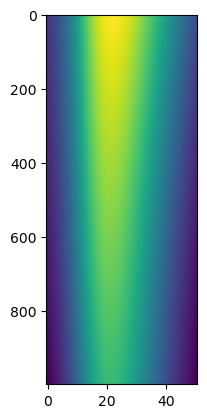

In [256]:
### INFERENCING STEP ###
t = features[:, 0]
x = features[:, 1]

with torch.inference_mode():
    prediction = model(torch.Tensor(x).reshape((x.shape[0],1)),
                       torch.Tensor(t).reshape((t.shape[0],1)))

plt.imshow(prediction.reshape_as(torch.Tensor(U)), aspect=0.125)

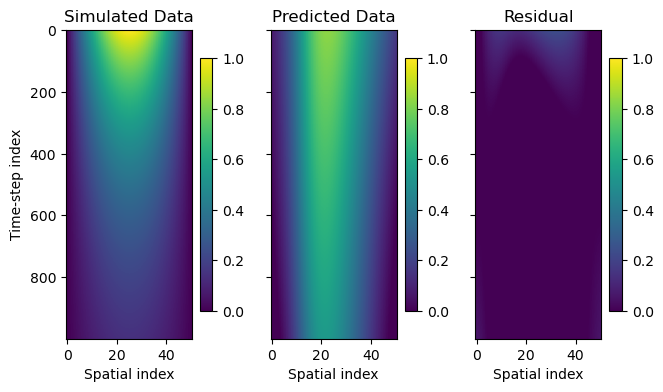

In [257]:
def result_plot(simulation, prediction):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    f.tight_layout()

    # Min and max of real data so plots share limits
    sim_min = np.min(simulation)
    sim_max = np.max(simulation)
    
    sim_im = ax1.imshow(simulation, aspect=0.125, vmin=sim_min, vmax=sim_max)
    pred_im = ax2.imshow(prediction, aspect=0.125, vmin=sim_min, vmax=sim_max)
    res_im = ax3.imshow(simulation-np.asarray(prediction), aspect=0.125, vmin=sim_min, vmax=sim_max)

    # Colorbars
    f.colorbar(sim_im, orientation='vertical', shrink=0.6)
    f.colorbar(pred_im, orientation='vertical', shrink=0.6)
    f.colorbar(res_im, orientation='vertical', shrink=0.6)  
    
    #Titles and labels
    ax1.set_title("Simulated Data")
    ax1.set_ylabel("Time-step index")
    ax1.set_xlabel("Spatial index")
    ax2.set_title("Predicted Data")
    ax2.set_xlabel("Spatial index")
    ax3.set_title("Residual")
    ax3.set_xlabel("Spatial index")
    
    # Make spacing suitable
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
    f.savefig("output_img.png")

prediction = prediction.reshape_as(torch.Tensor(U))
simulation = U
result_plot(simulation,prediction)